In [1]:
import rasterio
import rasterstats as rstats
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Reading Rasters with Rasterio

In [2]:
# plot one band
# provide the filepath name to the raster you want (this is the Near-Infrared band)
filepath =  "https://www.dropbox.com/scl/fi/jhlov245pautfmkggieop/LC09_L1TP_015033_20231103_20231103_02_T1_B5.TIF?rlkey=5ympdgn2bxnngsy4ke212xm7x&dl=1"

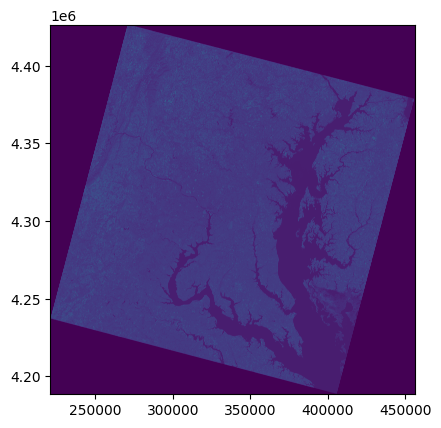

<Axes: >

In [3]:
#open the raster with rasterio and plot 
raster = rasterio.open(filepath)
show((raster, 1))

## Plot True Color Raster

In [4]:
# read in multiple bands

redband = "https://www.dropbox.com/scl/fi/riufhhwfd6ioqboe2ai4i/LC09_L1TP_015033_20231103_20231103_02_T1_B4.TIF?rlkey=ha19z35sk964jzqrvmfvfzl5u&dl=1"
grnband = "https://www.dropbox.com/scl/fi/a7vt3vi7hqzlaqy0v9f8b/LC09_L1TP_015033_20231103_20231103_02_T1_B3.TIF?rlkey=rnihwnu3mjg055qy8o4h9tq5z&dl=1"
bluband = "https://www.dropbox.com/scl/fi/noh7796lb0utx1b9lnime/LC09_L1TP_015033_20231103_20231103_02_T1_B2.TIF?rlkey=bze1j8quwq61vny9n6to48sx4&dl=1"
nirband = "https://www.dropbox.com/scl/fi/jhlov245pautfmkggieop/LC09_L1TP_015033_20231103_20231103_02_T1_B5.TIF?rlkey=5ympdgn2bxnngsy4ke212xm7x&dl=1"

with rasterio.open(redband) as src:
  red = src.read(1)

with rasterio.open(grnband) as src:
  grn = src.read(1)

with rasterio.open(bluband) as src:
  blu = src.read(1)

with rasterio.open(nirband) as src:
  nir = src.read(1)

In [5]:
# Function to normalize the grid values
def normalize(band):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))


In [6]:
# Normalize the bands
redn = normalize(red)
grnn = normalize(grn)
blun = normalize(blu)
nirn = normalize(nir)

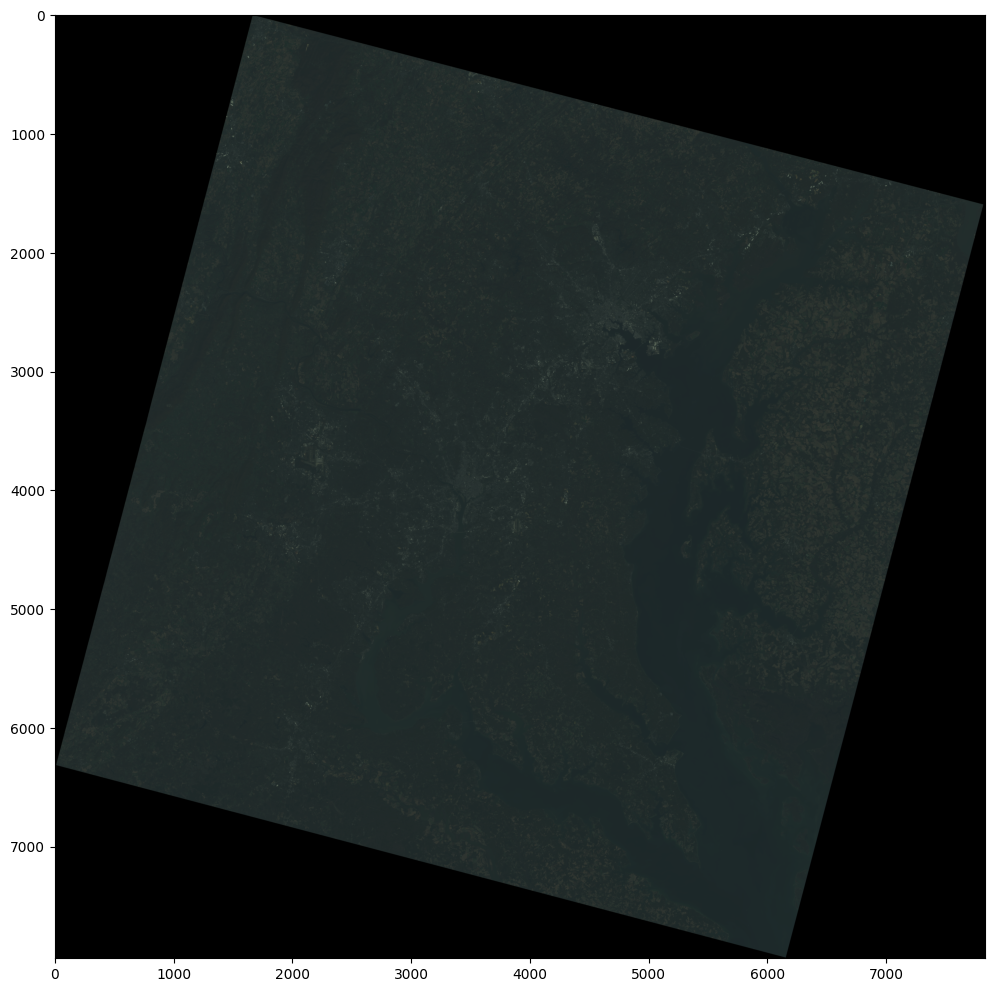

In [7]:
# Create RGB natural color composite
rgb = np.dstack((redn, grnn, blun))

# Plot the composite RGB image
plt.figure(figsize=(12,17))
plt.imshow(rgb, vmin=0, vmax=1)

## Plot NDVI

The Normalized Difference Vegetation Index (NDVI) is an idex that uses an image's Near-Infrared and Red bands to highlight the amount of "greenness" in an image

In [8]:
# create the NDVI function
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype(float)
    red = red.astype(float)
    ndvi = (nir - red) / (nir + red)
    return ndvi

In [9]:
# calculate the ndvi
ndvi = calc_ndvi(nirn,redn)

/var/folders/3m/_16xnwsd67v528sclbvr9by80000gr/T/ipykernel_17929/1271601868.py:6: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


Text(0, 0.5, 'Row #')

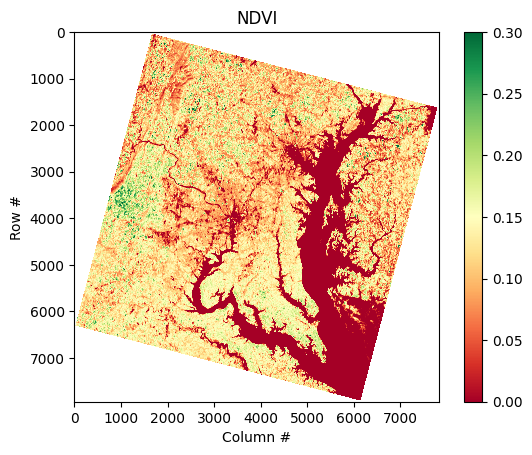

In [10]:
plt.imshow(ndvi, cmap='RdYlGn',vmin=0,vmax=.3) 
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')

## Zonal Statistics

We can get the average raster cell values for a set of vectors (polygons)

In [11]:
# define the top left corner (raster origin) and cell size
transform=rasterio.transform.from_origin(221085.0, 4426515.0, 30.0, 30.0 )

# define the coordinate system (UTM zone 18)
crs = rasterio.crs.CRS.from_epsg(32618)

#convert the NDVI matrix back into a raster (so that we can get the correct coordinate information)
with rasterio.open('MD_DC_VA.tif', 'w', driver='GTiff', 
                   height=ndvi.shape[0], width=ndvi.shape[1], 
                   count=1, dtype=ndvi.dtype, 
                   crs= crs,
                   transform=transform ) as output:
    output.write(ndvi,1) 
    output.close()  

In [12]:
# load the walksheds and read the ndvi raster back in 
walksheds = gpd.read_file('/Users/jkchap16/Library/CloudStorage/Box-Box/WMATA_DATA/Data/walksheds_overlapping.zip')
ndvi2 =rasterio.open('MD_DC_VA.tif')

In [13]:
# project the walksheds to the same coordinate system as the raster
walksheds = walksheds.to_crs(epsg=32618)

<Axes: >

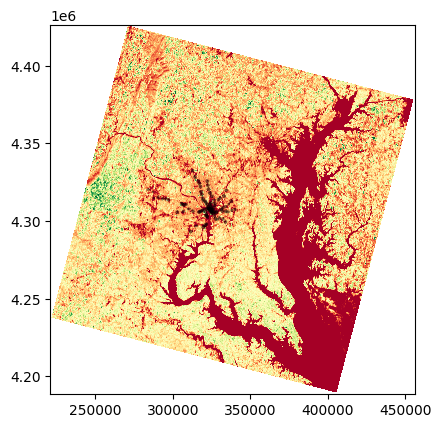

In [14]:
# plot both the ndvi raster and the walksheds
fig, ax = plt.subplots()
show(ndvi2, cmap='RdYlGn', ax=ax, vmin=0, vmax=.3)
walksheds.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)

In [15]:
#get the average ndvi per walkshed
walkshed_ndvi = rstats.zonal_stats(walksheds.geometry, 'MD_DC_VA.tif')
avg = [r['mean'] for r in walkshed_ndvi]
walksheds['ndvi'] = avg

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [16]:
# print the first few rows
walksheds.head()

,Name_1,Acres,Shape_Leng,Shape_Area,StnCode,geometry,ndvi
0,ADDISON ROAD-SEAT PLEASANT : 0 - 2640,246.285276,16545.122053,1.072814e+07,NaN,"POLYGON ((335215.925 4306467.785, 335291.359 4...",0.080149
1,ANACOSTIA : 0 - 2640,333.682311,20554.034340,1.453514e+07,NaN,"POLYGON ((326794.053 4304165.187, 326842.327 4...",0.025549
2,ARCHIVES-NAVY MEMORIAL-PENN QUARTER : 0 - 2640,364.582849,16402.785744,1.588117e+07,NaN,"POLYGON ((324685.595 4307708.704, 324777.141 4...",-0.026391
3,ARLINGTON CEMETERY : 0 - 2640,222.730244,20204.267483,9.702091e+06,NaN,"POLYGON ((320768.463 4306410.311, 320772.708 4...",0.127961
4,BALLSTON-MU : 0 - 2640,355.268037,17165.200672,1.547541e+07,NaN,"POLYGON ((317531.640 4306013.441, 317570.256 4...",-0.012866


<Axes: >

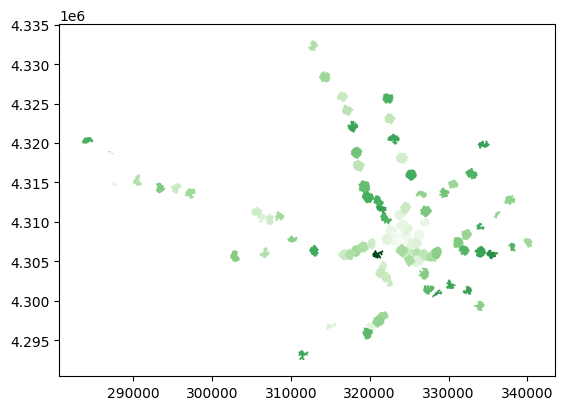

In [17]:
# choropleth map of walksheds and ndvi
walksheds.plot('ndvi', cmap='Greens')